# Import Libraries

In [1]:
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
from tensorflow.keras.layers import Flatten, LSTM, Dropout, Bidirectional, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Conv2DTranspose, BatchNormalization, Activation, ConvLSTM2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle

import cv2

C:\Users\Owner\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
num_train = 250
num_frames = 32
num_val = 100
num_test = 100
step_size = 2

# Import and split dataset

In [3]:
volume_tracings = pd.read_csv('VolumeTracings.csv')
file_list = pd.read_csv('FileList.csv')

# create a list of our conditions
conditions = [
    (file_list['EF'] <= 55) | (file_list['EF'] > 75),
    (file_list['EF'] > 55) & (file_list['EF'] <= 75)  
    ]
#https://www.webmd.com/heart-disease/handling-cardiac-emergencies
# Adding normal and abnormal classifications
values = ['Abnormal', 'Normal']
file_list['HeartCondition'] = np.select(conditions, values)

# only takes in the files where frame height and frame width are 112
adjusted_file_list = file_list[(file_list['FrameHeight'] == 112) & (file_list['FrameWidth'] == 112) & (file_list['NumberOfFrames'] > num_frames*step_size)]

train_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'TRAIN']
val_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'VAL']
test_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'TEST']

# Import model

In [5]:
def my_weighted_loss(labels, logits):
    """scale loss based on class weights
    """
    # reshape 
    labels = tf.reshape(labels, [-1,1])
    logits = tf.reshape(logits, [-1,1])
    # compute weights based on their frequencies (higher weight to class 1 since it's less common)
    class_weights = [1., 2.5]
    # compute weights based on labels
    labels = tf.cast(labels, tf.float32)
    weights = labels*(class_weights[1]-class_weights[0]) + class_weights[0]
    
    weights = tf.reshape(weights, [-1])
    
    
    # compute (unweighted) softmax cross entropy loss
    unweighted_losses = tf.keras.losses.binary_crossentropy(labels, logits)
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    return loss


In [6]:
sd = 2
input_size = (112,112,1)
N_1 = input_size[0]
N_2 = input_size[1]
inputs = Input(input_size) 
conv1 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# D1
conv4 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
conv4_1 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4_1 = Dropout(0.5)(conv4_1)
# D2
conv4_2 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
conv4_2 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
conv4_2 = Dropout(0.5)(conv4_2)
# D3
merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
conv4_3 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
conv4_3 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
drop4_3 = Dropout(0.5)(conv4_3)

up6 = Conv2DTranspose(int(256/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
up6 = BatchNormalization(axis=3)(up6)
up6 = Activation('relu')(up6)

x1 = Reshape(target_shape=(1, np.int32(N_1/4), np.int32(N_2/4), int(256/sd)))(drop3)
x2 = Reshape(target_shape=(1, np.int32(N_1/4), np.int32(N_2/4), int(256/sd)))(up6)
merge6  = concatenate([x1,x2], axis = 1) 
merge6 = ConvLSTM2D(filters = int(128/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
conv6 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2DTranspose(int(128/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
up7 = BatchNormalization(axis=3)(up7)
up7 = Activation('relu')(up7)

x1 = Reshape(target_shape=(1, np.int32(N_1/2), np.int32(N_2/2), int(128/sd)))(conv2)
x2 = Reshape(target_shape=(1, np.int32(N_1/2), np.int32(N_2/2), int(128/sd)))(up7)
merge7  = concatenate([x1,x2], axis = 1) 
merge7 = ConvLSTM2D(filters = int(64/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
conv7 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2DTranspose(int(64/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
up8 = BatchNormalization(axis=3)(up8)
up8 = Activation('relu')(up8)    

x1 = Reshape(target_shape=(1, N_1, N_2, int(64/sd)))(conv1)
x2 = Reshape(target_shape=(1, N_1, N_2, int(64/sd)))(up8)
merge8  = concatenate([x1,x2], axis = 1) 
merge8 = ConvLSTM2D(filters = int(32/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
conv8 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)
# trying this out in order to weight the samples...
# outputs = Reshape((N_1*N_2, 1))(conv9)

model = Model(inputs = inputs, outputs = conv9)
# modify learning rate, change loss??? before it was cross entropy
model.compile(optimizer = Adam(lr = 1e-3), loss = my_weighted_loss, metrics = ['accuracy'])
# model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
# plot_model(model)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [7]:
model.load_weights('segmentation_model.h5')

# Return frames from videos

In [8]:
def get_frame_from_video(frame_number, filename):
    cap = cv2.VideoCapture('Videos/' + filename)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    res, image = cap.read()
    return image

In [9]:
# returns a bunch of frames from videos
def get_frames_from_videos(filenames, num_frames, num_videos, step_size=1):
    frames = []
    # loop through a certain number of videos
    for i in range(num_videos):
        frames_in_video = []
        # loop through a certain # of frames in that video
        for j in range(num_frames):
            # returns the jth frame from the ith video in filenames
            frame = get_frame_from_video(j*step_size, filenames[i])
            frames_in_video.append(frame)

        frames.append(frames_in_video)
    return frames

In [10]:
# ordering is preserved
train_filenames = train_file_list.FileName.unique() + '.avi'
val_filenames = val_file_list.FileName.unique() + '.avi'
test_filenames = test_file_list.FileName.unique() + '.avi'



train_frames = get_frames_from_videos(filenames=train_filenames, num_frames = num_frames, num_videos=num_train, step_size=step_size)
train_files_used = train_file_list[:num_train]
train_labels = pd.get_dummies(train_files_used["HeartCondition"])

val_frames = get_frames_from_videos(filenames=val_filenames, num_frames = num_frames, num_videos=num_val, step_size=step_size)
val_files_used = val_file_list[:num_val]
val_labels = pd.get_dummies(val_files_used["HeartCondition"])

test_frames = get_frames_from_videos(filenames=test_filenames, num_frames = num_frames, num_videos=num_test, step_size=step_size)
test_files_used = test_file_list[:num_test]
test_labels = pd.get_dummies(test_files_used["HeartCondition"])

In [11]:
val_labels

,Abnormal,Normal
0,1,0
4,1,0
11,0,1
26,0,1
34,0,1
...,...,...
687,1,0
707,0,1
713,1,0
718,0,1


In [12]:
train_frames = tf.constant(train_frames)
val_frames = tf.constant(val_frames)
test_frames = tf.constant(test_frames)

# Get predictions from model on frames (reshape frames if necessary)

In [13]:
resized_train_frames = tf.expand_dims(tf.reduce_mean(train_frames, axis=4), axis=-1)
preds = []
for i in resized_train_frames:
    preds.append(model.predict(i))
preds = np.array(preds)
predicted_train_label = np.where(preds > 0.5, 1, 0)

In [14]:
resized_val_frames = tf.expand_dims(tf.reduce_mean(val_frames, axis=4), axis=-1)
preds = []
for i in resized_val_frames:
    preds.append(model.predict(i))
preds = np.array(preds)
predicted_val_label = np.where(preds > 0.5, 1, 0)

In [15]:
resized_test_frames = tf.expand_dims(tf.reduce_mean(test_frames, axis=4), axis=-1)
preds = []
for i in resized_test_frames:
    preds.append(model.predict(i))
preds = np.array(preds)
predicted_test_label = np.where(preds > 0.5, 1, 0)

# Color the pixels where prediction is positive class blue

In [16]:
predicted_train_label = tf.constant(predicted_train_label)
predicted_val_label = tf.constant(predicted_val_label)
predicted_test_label = tf.constant(predicted_test_label)

In [17]:
colored_train_frames = train_frames+predicted_train_label*[-50, -50, 50]
colored_train_frames = tf.clip_by_value(colored_train_frames, 0, 255)

In [18]:
colored_val_frames = val_frames+predicted_val_label*[-50, -50, 50]
colored_val_frames = tf.clip_by_value(colored_val_frames, 0, 255)

In [19]:
colored_test_frames = test_frames+predicted_test_label*[-50, -50, 50]
colored_test_frames = tf.clip_by_value(colored_test_frames, 0, 255)

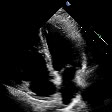

In [20]:
train_frame_images = []
for i in train_frames:
    vid_images = []
    for j in i:
        image = array_to_img(j)
        vid_images.append(image)
    train_frame_images.append(vid_images)
train_frame_images[0][0]

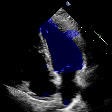

In [21]:
colored_train_frame_images = []
for i in colored_train_frames:
    colored_vid_images = []
    for j in i:
        image = array_to_img(j)
        colored_vid_images.append(image)
    colored_train_frame_images.append(colored_vid_images)
colored_train_frame_images[0][0]

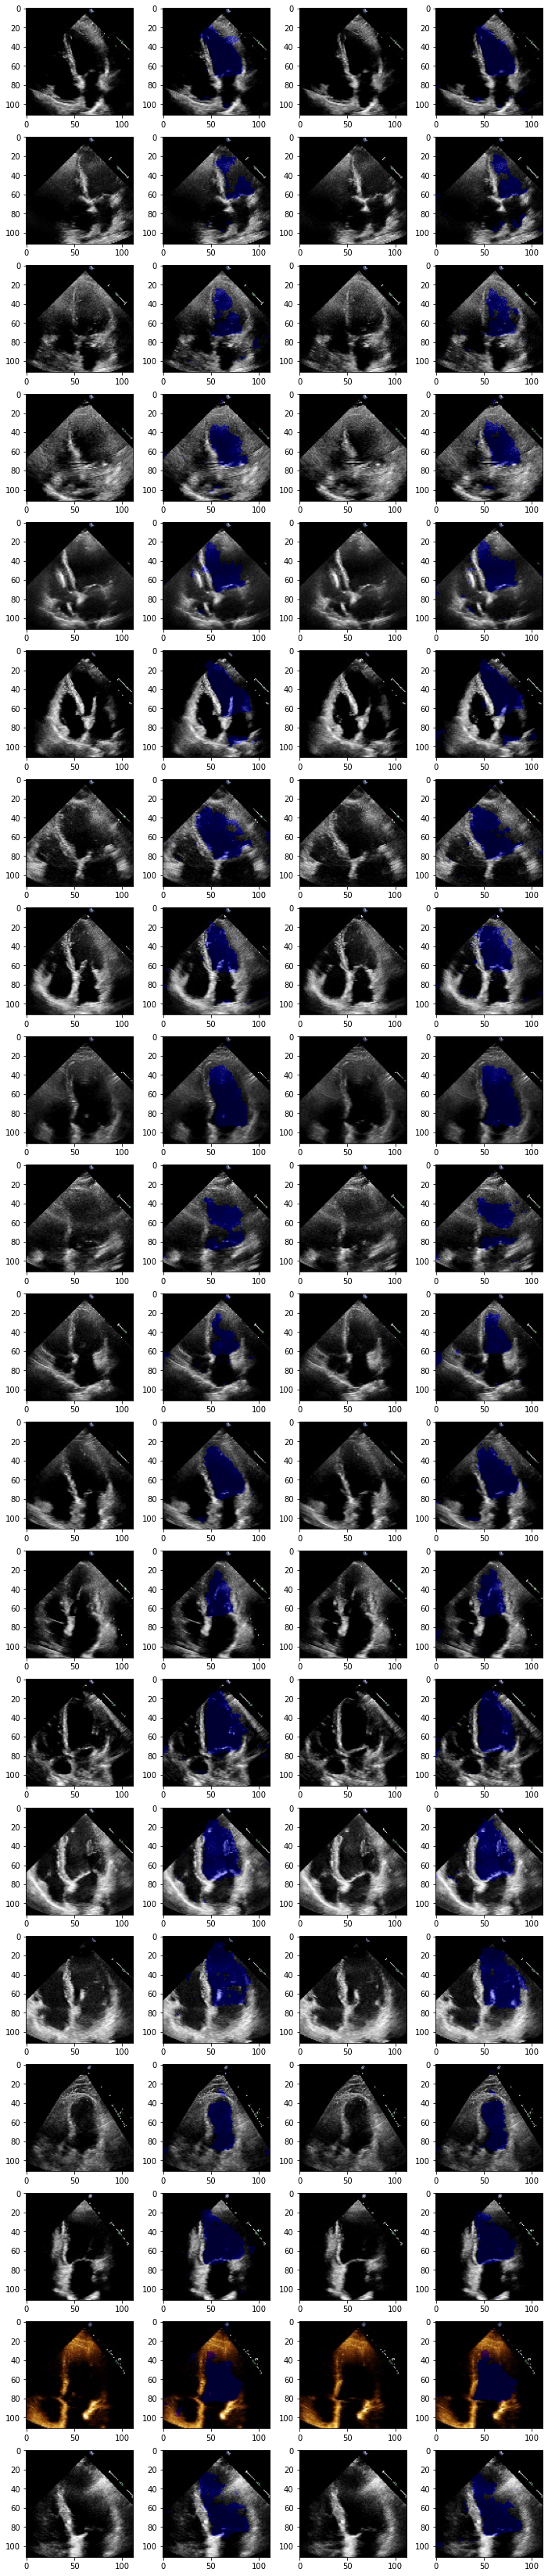

In [22]:
import matplotlib.pyplot as plt
num_samples = 20
f, axarr = plt.subplots(num_samples,4,figsize=(12,num_samples*3))
for i in range(num_samples):
    axarr[i, 0].imshow(train_frame_images[i][0])
    axarr[i, 1].imshow(colored_train_frame_images[i][0])
    axarr[i, 2].imshow(train_frame_images[i][1])
    axarr[i, 3].imshow(colored_train_frame_images[i][1])


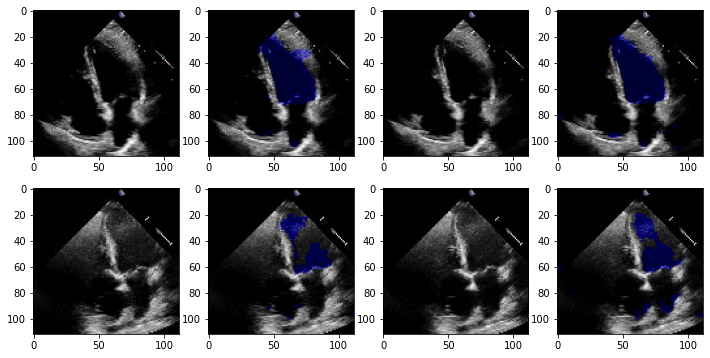

In [23]:
num_samples = 2
f, axarr = plt.subplots(num_samples,4,figsize=(12,num_samples*3))
for i in range(num_samples):
    axarr[i, 0].imshow(train_frame_images[i][0])
    axarr[i, 1].imshow(colored_train_frame_images[i][0])
    axarr[i, 2].imshow(train_frame_images[i][1])
    axarr[i, 3].imshow(colored_train_frame_images[i][1])

In [24]:
# normalize data to prepare for classification model
colored_train_frames = tf.cast(colored_train_frames, dtype=tf.float32)
colored_train_frames_normalized = colored_train_frames/255
colored_val_frames = tf.cast(colored_val_frames, dtype=tf.float32)
colored_val_frames_normalized = colored_val_frames/255
colored_test_frames = tf.cast(colored_test_frames, dtype=tf.float32)
colored_test_frames_normalized = colored_test_frames/255
type(colored_train_frames_normalized)

tensorflow.python.framework.ops.EagerTensor

In [26]:
# save the file
with open('class_train_gpu.npy', 'wb') as f:
    np.save(f, colored_train_frames_normalized)
    np.save(f, train_labels)
with open('class_val_gpu.npy', 'wb') as f:
    np.save(f, colored_val_frames_normalized)
    np.save(f, val_labels)
with open('class_test_gpu.npy', 'wb') as f:
    np.save(f, colored_test_frames_normalized)
    np.save(f, test_labels)